# Evaluation: RAG Performance on the EU AI Act

## Overview

This notebook evaluates the retrieval accuracy and generation quality of a RAG system designed to answer questions regarding the EU AI Act. We compare performance across two variables:

1. **Conversation Complexity:** Single-turn (one-off questions) vs. Multi-turn (ongoing dialogues).
2. **Retrieval Strategy:** Standard retrieval vs. Retrieval enhanced with a Cross-Encoder Reranker.

## Summary of Results

| Evaluation Scenario | Total Queries | Retrieval Hit Rate | Avg. RAG Score (/10) | Avg. Baseline (/10) |
| --- | --- | --- | --- | --- |
| **Single Turn** | 747 | 92.8% | 8.27 | 5.56 |
| **Single Turn (Reranked)** | 747 | **96.4%** | **8.39** | 5.38 |
| **Multi-Turn** | 228 | 72.4% | 7.30 | 6.59 |
| **Multi-Turn (Reranked)** | 228 | **75.9%** | **7.51** | 6.61 |


**Evaluation Disclaimer:**
The quality scores presented in this evaluation (ranging from 1 to 10) were generated using an **LLM-as-a-Judge** framework. This automated process assesses and compares the responses from both the **Baseline** (LLM only) and the **RAG pipeline** against a predefined **Ground Truth** (the correct legal reference from the AI Act) to determine accuracy, relevance, and completeness.



In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import numpy as np
from matplotlib.patches import Patch
import sys
sys.path.append(str(Path.cwd().parent))

project_root = Path.cwd().parent 

def load_processed_data(file_path, is_multi=False):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    
    if is_multi:
        df['Retrieval Status'] = df['is_hit'].map({True: 'Success', False: 'Fail'})
    else:
        df['Retrieval Status'] = df['hit_rank'].apply(lambda x: 'Success' if x > 0 else 'Fail')
    
    return df
single_path= project_root / "results/rag_eval_full_single_queries_20260112_200932.json" 
single_reranked_path= project_root / "results/rag_eval_full_single_turn_reranked_20260113_020921.json" 

multi_path  = project_root / "results/rag_eval_full_multi_turn_20260114_215828.json" 
multi_reranked_path  = project_root / "results/rag_eval_full_multi_turn_reranked_20260114_202740.json" 


df_single = load_processed_data(single_path, is_multi=False)
df_multi = load_processed_data(multi_path, is_multi=True)
df_single_reranked = load_processed_data(single_reranked_path, is_multi=False)
df_multi_reranked = load_processed_data(multi_reranked_path, is_multi=True)


## Data Interpretation

### 1. The Impact of Reranking

Across both single and multi-turn datasets, the **Reranking approach consistently outperforms** the standard RAG setup.

* **Retrieval Boost:** In single-turn queries, reranking reduced retrieval failures by exactly **50%** (dropping from 54 failures to 27), pushing the hit rate to **96.4%**. We also observe a significant jump in ranking quality, with the Mean Reciprocal Rank (MRR) improving from **0.794 to 0.869**.
* **Quality Gain:** The average RAG score increased in both scenarios when reranking was applied (rising from 8.27 to **8.39** in single-turn). This confirms that the Cross-Encoder better prioritizes the most relevant legal context, leading to more accurate answers.

### 2. Single Turn vs. Multi-Turn Performance

There is a noticeable performance gap between single-turn and multi-turn conversations, though the system remains robust.

* **Retrieval Challenge:** The retrieval hit rate drops by approximately **17%** in multi-turn settings (falling from 92.8% to 75.9%). This difficulty is further reflected in the MRR, which decreases from 0.794 to **0.558**. This is likely due to "query drift" and the complexity of resolving coreferences in follow-up questions.
* **Generation Quality:** Despite the retrieval difficulty, RAG scores remain healthy in multi-turn sessions (**7.42**) compared to single-turn (**8.27**). Even in these complex dialogues, the RAG system maintains a clear advantage over the baseline score of 6.62.

### Summary Comparison Table

| Metric | Single Turn (Std) | Single Turn (Rerank) | Multi Turn (Std) | Multi Turn (Rerank) |
| --- | --- | --- | --- | --- |
| **Hit Rate** | 92.8% | **96.4%** | 75.9% | 79.4% |
| **MRR** | 0.794 | **0.869** | 0.558 | 0.645 |
| **Avg Score** | 8.27 | **8.39** | 7.42 | 7.62 |

In [12]:
def generate_summary(df, label):
    total = len(df)
    
    if 'hit_rank' in df.columns:
        df['rr'] = df['hit_rank'].apply(lambda x: 1/x if x > 0 else 0)
        mrr = df['rr'].mean()
    else:
        mrr = 0.0 

    successes = len(df[df['Retrieval Status'] == 'Success'])
    fails = len(df[df['Retrieval Status'] == 'Fail'])
    hit_rate = (successes / total) * 100
    
    print(f"--- Summary for {label} ---")
    print(f"Total Queries:       {total}")
    print(f"Retrieval Hits:      {successes}")
    print(f"Retrieval Hit Rate:  {hit_rate:.1f}%")
    print(f"Mean Reciprocal Rank (MRR): {mrr:.3f}")
    print(f"Avg. RAG Score:      {df['rag_score'].mean():.2f} / 10.0")
    print(f"Avg. Baseline Score: {df['baseline_score'].mean():.2f} / 10.0\n")

generate_summary(df_single, "Single Turn")
generate_summary(df_multi, "Multi Turn")
generate_summary(df_single_reranked, "Single Turn Reranked")
generate_summary(df_multi_reranked, "Multi Turn Reranked")

--- Summary for Single Turn ---
Total Queries:       747
Retrieval Hits:      693
Retrieval Hit Rate:  92.8%
Mean Reciprocal Rank (MRR): 0.794
Avg. RAG Score:      8.27 / 10.0
Avg. Baseline Score: 5.56 / 10.0

--- Summary for Multi Turn ---
Total Queries:       228
Retrieval Hits:      173
Retrieval Hit Rate:  75.9%
Mean Reciprocal Rank (MRR): 0.558
Avg. RAG Score:      7.42 / 10.0
Avg. Baseline Score: 6.62 / 10.0

--- Summary for Single Turn Reranked ---
Total Queries:       747
Retrieval Hits:      720
Retrieval Hit Rate:  96.4%
Mean Reciprocal Rank (MRR): 0.869
Avg. RAG Score:      8.39 / 10.0
Avg. Baseline Score: 5.38 / 10.0

--- Summary for Multi Turn Reranked ---
Total Queries:       228
Retrieval Hits:      181
Retrieval Hit Rate:  79.4%
Mean Reciprocal Rank (MRR): 0.645
Avg. RAG Score:      7.62 / 10.0
Avg. Baseline Score: 6.43 / 10.0



### 3. Conversation Decay

The "Conversation Decay" visualizations use stacked bar charts to decompose performance into **Success** (Green), **Hallucination** (Red), and **Refusals** (Grey). This granular view reveals distinct behaviors between the two systems as the dialogue progresses.

#### **Standard RAG Pipeline (Hatched Bars)**

* **High Initial Reliability:** The RAG system demonstrates robust performance at **Turn 1**, where the bar is dominated by "Success" (green). Hallucinations and Refusals are minimal, confirming that the retrieval mechanism is highly effective for the initial, context-free query.
* **Safety Mechanism vs. Decay:** As the conversation progresses to **Turn 2 and Turn 3**, the proportion of "Success" decreases. However, the charts reveal a crucial insight: this is not driven solely by errors. Instead, we see a growing segment of **Refusals (grey)**. This suggests the system is failing *safely*—when it struggles to retrieve context for complex follow-up questions, it prefers to refuse answering rather than fabricating information.

#### **Baseline System (Solid Bars)**

* **Dominance of Hallucinations:** The Baseline struggles significantly at the start, with **Turn 1** comprising mostly **Hallucinations (red)**. Without access to the external documents, the model frequently attempts to answer but fails to meet the accuracy threshold.
* **The "Confidence Trap":** While the Baseline actually improves in Turns 2 and 3 (with the green "Success" block growing), it stands in sharp contrast to the RAG system regarding safety. The Baseline **almost never refuses** (absence of grey segments). It forces an answer every time, meaning any gap in knowledge results directly in a hallucination rather than a safe refusal.

#### **Reranked RAG Pipeline**

* **Performance Recovery:** In contrast to the standard pipeline, the **Reranked RAG** system shows more resilience. While it also experiences the complexity of multi-turn dialogues, the **Reranked Multi-Turn RAG score (7.62)** remains higher than the Standard Multi-Turn score (7.42).
* **The Reranking Advantage:** This suggests that the Cross-Encoder Reranker is more effective at navigating "messy" multi-turn queries, converting potential "Refusals" or "Hallucinations" back into "Successes" by surfacing the correct document even when the query is ambiguous.

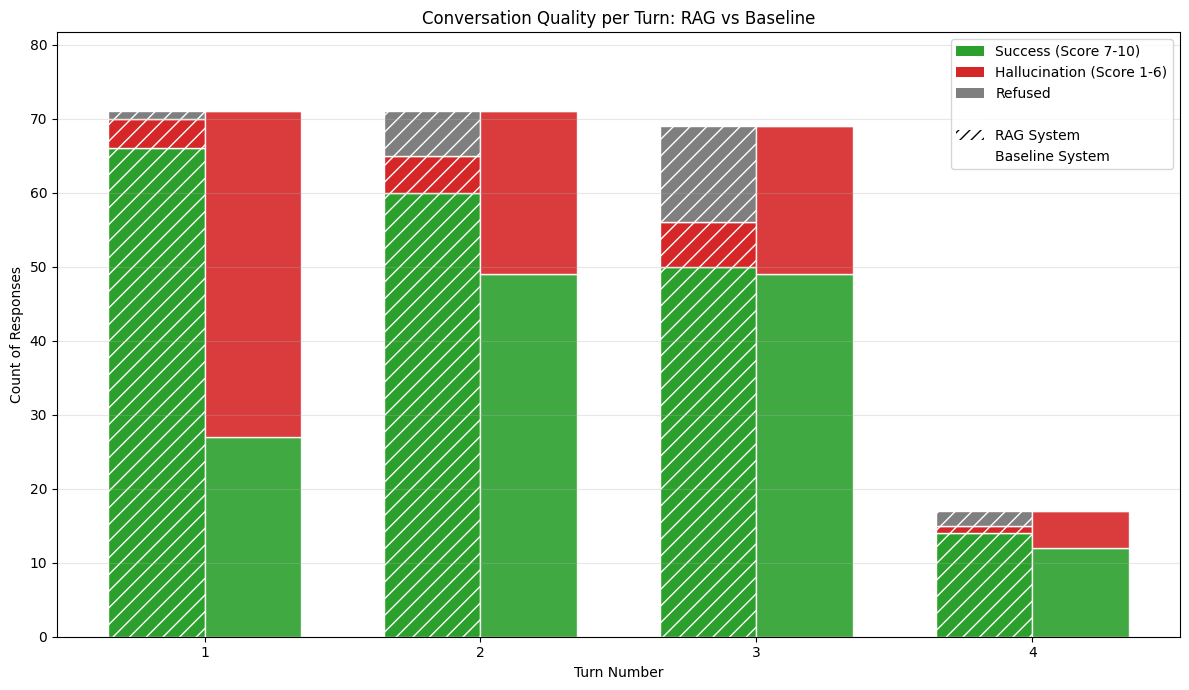

In [15]:
from sympy import plot


def categorize_response(row, answer_col, score_col):
    ans_text = str(row[answer_col]).lower()
    if "i cannot answer" in ans_text:
        return "Refused"
    
    score = row[score_col]
    if score >= 7:
        return "Success"
    else:
        return "Hallucination"

def get_counts(df, status_col):
    counts = df.groupby(['turn_number', status_col]).size().unstack(fill_value=0)
    for cat in ['Success', 'Hallucination', 'Refused']:
        if cat not in counts.columns:
            counts[cat] = 0
    return counts[['Success', 'Hallucination', 'Refused']]

def plot_comparison(rag_counts, baseline_counts):
    fig, ax = plt.subplots(figsize=(12, 7))

    turns = rag_counts.index
    x = np.arange(len(turns))
    width = 0.35

    colors = {
        'Success': '#2ca02c',       # Green
        'Hallucination': '#d62728', # Red
        'Refused': '#7f7f7f'        # Gray
    }

    bottom = np.zeros(len(turns))
    for cat in ['Success', 'Hallucination', 'Refused']:
        ax.bar(x - width/2, rag_counts[cat], width, bottom=bottom, 
            color=colors[cat], hatch='//', edgecolor='white')
        bottom += rag_counts[cat]

    bottom = np.zeros(len(turns))
    for cat in ['Success', 'Hallucination', 'Refused']:
        ax.bar(x + width/2, baseline_counts[cat], width, bottom=bottom, 
            color=colors[cat], alpha=0.9, edgecolor='white')
        bottom += baseline_counts[cat]

    max_y = max(rag_counts.sum(axis=1).max(), baseline_counts.sum(axis=1).max())
    ax.set_ylim(0, max_y * 1.15)

    ax.set_xlabel("Turn Number")
    ax.set_ylabel("Count of Responses")
    ax.set_title("Conversation Quality per Turn: RAG vs Baseline")
    ax.set_xticks(x)
    ax.set_xticklabels(turns)
    ax.grid(axis='y', alpha=0.3)

    legend_elements = [
        Patch(facecolor=colors['Success'], label='Success (Score 7-10)'),
        Patch(facecolor=colors['Hallucination'], label='Hallucination (Score 1-6)'),
        Patch(facecolor=colors['Refused'], label='Refused'),
        Patch(facecolor='white', label=''), 
        Patch(facecolor='white', hatch='///', label='RAG System', alpha=0.5),
        Patch(facecolor='white', label='Baseline System', alpha=0.5)
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

df_multi['rag_status'] = df_multi.apply(
    lambda x: categorize_response(x, 'rag_answer', 'rag_score'), axis=1
)
df_multi['baseline_status'] = df_multi.apply(
    lambda x: categorize_response(x, 'baseline_answer', 'baseline_score'), axis=1
)

rag_counts = get_counts(df_multi, 'rag_status')
baseline_counts = get_counts(df_multi, 'baseline_status')

plot_comparison(rag_counts, baseline_counts)


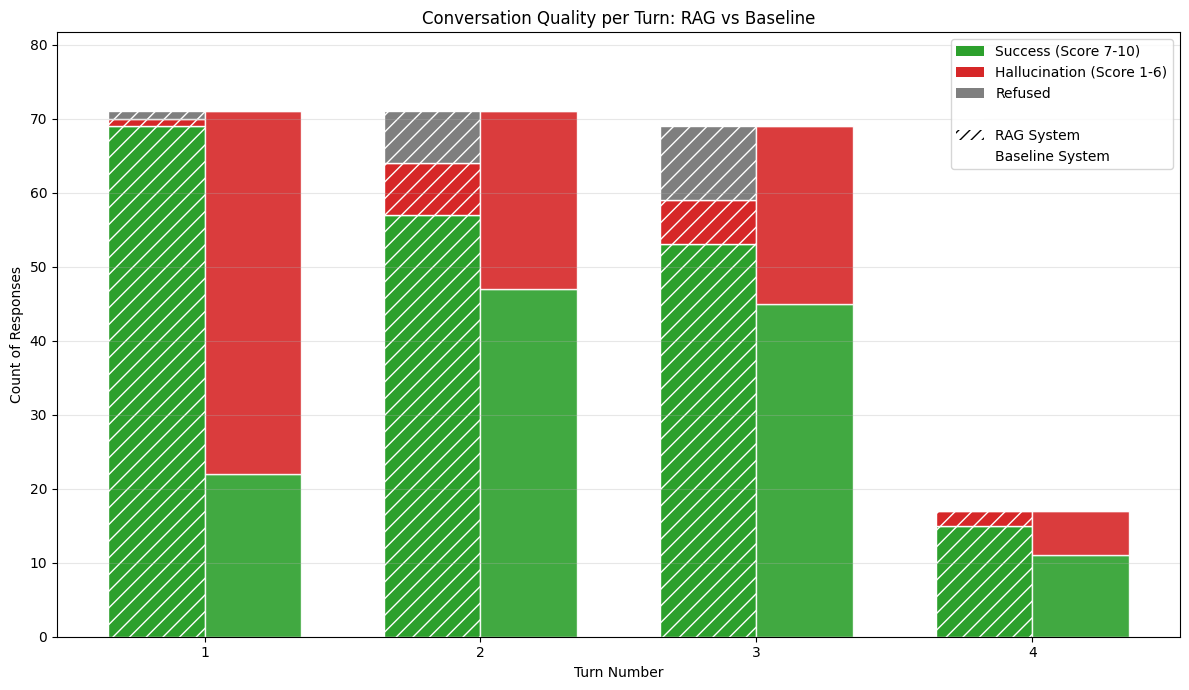

In [16]:
df_multi_reranked['rag_status'] = df_multi_reranked.apply(
    lambda x: categorize_response(x, 'rag_answer', 'rag_score'), axis=1
)
df_multi_reranked['baseline_status'] = df_multi_reranked.apply(
    lambda x: categorize_response(x, 'baseline_answer', 'baseline_score'), axis=1
)

rag_counts = get_counts(df_multi_reranked, 'rag_status')
baseline_counts = get_counts(df_multi_reranked, 'baseline_status')

plot_comparison(rag_counts, baseline_counts)

### 4. Analysis: Impact of Retrieval on Generation

A critical part of this evaluation is understanding the **correlation between retrieval and generation**. The chart above illustrates the "RAG Lift"—the measurable value added by grounding the model in the actual text of the law.

* **The "Fall-back" Effect:** When retrieval fails (red bars), the RAG score drops significantly, effectively falling back to the performance level of the Baseline LLM (~5.5). This proves that the LLM alone does not have enough specific knowledge of the AI Act to provide high-quality legal answers.
* **Success:** A successful retrieval event (green bars) boosts the answer quality from roughly 5.5 to 8.5.
* **Strict Evaluation & Error Bars:** It is important to note that our "hit" criteria for correct citation is quite strict. Due to document overlap and hierarchical flattening in the data processing stage, information is often spread across multiple chunks. This means the model can often synthesize correct answers from related context available in other retrieved segments.

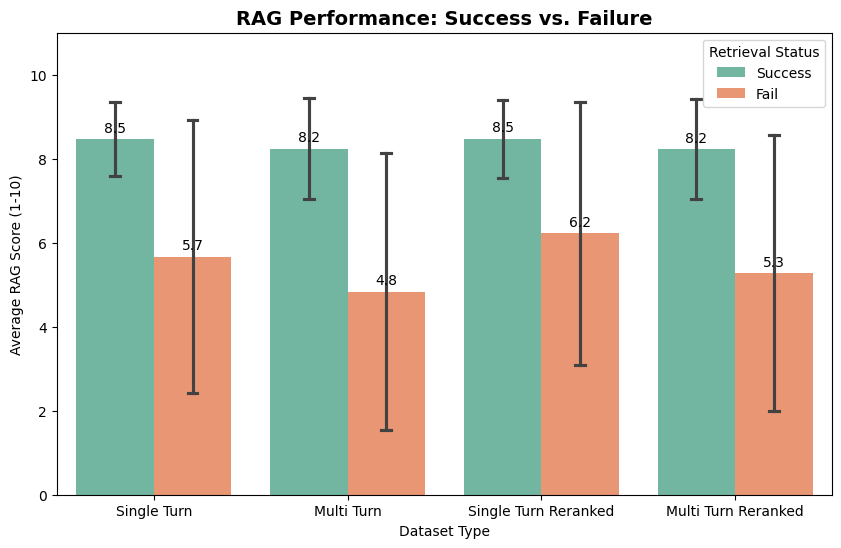

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

combined = pd.concat([
    df_single.assign(Dataset='Single Turn'),
    df_multi.assign(Dataset='Multi Turn'),
    df_single_reranked.assign(Dataset='Single Turn Reranked'),
    df_multi_reranked.assign(Dataset='Multi Turn Reranked')
])
plt.figure(figsize=(10, 6))

sns.barplot(
    data=combined, 
    x='Dataset', 
    y='rag_score', 
    hue='Retrieval Status', 
    palette='Set2',
    capsize=.1,
    errorbar="sd" 
)

plt.title("RAG Performance: Success vs. Failure", fontsize=14, fontweight='bold')
plt.ylabel("Average RAG Score (1-10)")
plt.xlabel("Dataset Type")
plt.ylim(0, 11)
plt.legend(title="Retrieval Status", loc='upper right')

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f', padding=3)

plt.show()